**Analysis Notebook**

In [3]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tabulate import tabulate

sns.set_theme(style='ticks', context='paper')

In [4]:
# Constants
ENERGY_CONSUMPTION = "Energy Consumption (exc. PUE)"
ENERGY_CONSUMPTION_PUE = "Energy Consumption (inc. PUE)"
MEMORY_CONSUMPTION = "Memory Energy Consumption (exc. PUE)"
MEMORY_CONSUMPTION_PUE = "Memory Energy Consumption (inc. PUE)"
CARBON_EMISSIONS = "Carbon Emissions"

only_workflows = ['chipseq', 'rangeland']
ci_intervals = ['de-15112023-08122023', 'de-09052023-01082023']
workflows_avg_paths = [f'data/temporal-shifting/entire-wf/{workflow}-avg/summary-{workflow}/' for workflow in only_workflows]
workflows_avg_files = [[f'{workflow_avg_path}{workflow}-{iteration}-summary.txt' for iteration in range(1,4)] for (workflow_avg_path, workflow) in zip(workflows_avg_paths, only_workflows)] 
workflows_avg_folders = [f'data/temporal-shifting/entire-wf/{workflow}-avg/' for workflow in only_workflows]
workflows_marg_folders = [f'data/temporal-shifting/entire-wf/{workflow}-marg/' for workflow in only_workflows]

In [5]:
def parse_explorer_summary(explorer_data):
    with open(explorer_data, 'r') as f:
        data = [line.strip().split(',') for line in f.readlines()]

    for row in data:
        if '~' in row[0]:
            shift_ms = row[0].split('~')[1][:-4]
            days = int(shift_ms.split('-')[0])
            hours = int(shift_ms.split('-')[1])
            shift_h = (days * 24) + hours
            row[0] = shift_h
        else:
            row[0] = 0

    data_d = {}

    for row in data:
        data_d[row[0]] = {'emissions': row[1]}

    return data_d


def get_minimum(data):
    minimum = float(data[0]['emissions'])
    shift = 0

    for key, entry in data.items():
        if float(entry['emissions']) < minimum:
            minimum = float(entry['emissions'])
            shift = key

    return (shift, minimum)


def get_reduction(original, new):
    orig = float(original)
    neww = float(new)
    return ((orig - neww) / abs(orig)) * 100


def overview(trace, print=False):
    data = parse_explorer_summary(trace)
    (min_shift, min_emissions) = get_minimum(data)

    if print:
        print(f"Original [0] CCF {data[0]['emissions']} gCO2e")  # original
        print(f"Minimum [{min_shift}] CCF {min_emissions} gCO2e")  # minimum
        print(f"Reduction {get_reduction(data[0]['emissions'], min_emissions):.2f}%")

    return (data, min_shift, min_emissions)


def average(one, two, three):
    return (float(one) + float(two) + float(three)) / 3

In [6]:
def parse_ts_summary_file(file):
    with open(file, 'r') as f:
        lines = f.readlines()[1:]

    props = {}

    for line in lines:
        parts = line.split(',')
        workflow = parts[0].split('-')[0]
        footprint = float(parts[1])
        entry_6h = parts[2].split(':')
        entry_12h = parts[3].split(':')
        entry_24h = parts[4].split(':')
        entry_48h = parts[5].split(':')
        entry_96h = parts[6].split(':')

        if workflow not in props:
            props[workflow] = {
                "FOOTPRINT": [footprint],
                "6H_FOOTPRINT": [float(entry_6h[1])],
                "6H_REDUCTION": [float(entry_6h[0][:-1])],
                "6H_OVERHEAD": [float(entry_6h[2])],
                "12H_FOOTPRINT": [float(entry_12h[1])],
                "12H_REDUCTION": [float(entry_12h[0][:-1])],
                "12H_OVERHEAD": [float(entry_12h[2])],
                "24H_FOOTPRINT": [float(entry_24h[1])],
                "24H_REDUCTION": [float(entry_24h[0][:-1])],
                "24H_OVERHEAD": [float(entry_24h[2])],
                "48H_FOOTPRINT": [float(entry_48h[1])],
                "48H_REDUCTION": [float(entry_48h[0][:-1])],
                "48H_OVERHEAD": [float(entry_48h[2])],
                "96H_FOOTPRINT": [float(entry_96h[1])],
                "96H_REDUCTION": [float(entry_96h[0][:-1])],
                "96H_OVERHEAD": [float(entry_96h[2])]
            }
        else: 
            props[workflow]["FOOTPRINT"].append(footprint)
            props[workflow]["6H_FOOTPRINT"].append(float(entry_6h[1]))
            props[workflow]["6H_REDUCTION"].append(float(entry_6h[0][:-1]))
            props[workflow]["6H_OVERHEAD"].append(float(entry_6h[2]))
            props[workflow]["12H_FOOTPRINT"].append(float(entry_12h[1]))
            props[workflow]["12H_REDUCTION"].append(float(entry_12h[0][:-1]))
            props[workflow]["12H_OVERHEAD"].append(float(entry_12h[2]))
            props[workflow]["24H_FOOTPRINT"].append(float(entry_24h[1]))
            props[workflow]["24H_REDUCTION"].append(float(entry_24h[0][:-1]))
            props[workflow]["24H_OVERHEAD"].append(float(entry_24h[2]))
            props[workflow]["48H_FOOTPRINT"].append(float(entry_48h[1]))
            props[workflow]["48H_REDUCTION"].append(float(entry_48h[0][:-1]))
            props[workflow]["48H_OVERHEAD"].append(float(entry_48h[2]))
            props[workflow]["96H_FOOTPRINT"].append(float(entry_96h[1]))
            props[workflow]["96H_REDUCTION"].append(float(entry_96h[0][:-1]))
            props[workflow]["96H_OVERHEAD"].append(float(entry_96h[2]))

    data = {}

    for workflow in only_workflows:
        footprint_6h = sum(props[workflow]["6H_FOOTPRINT"]) / 3
        reduction_6h = sum(props[workflow]["6H_REDUCTION"]) / 3
        # reduction_6h = max(props[workflow]["6H_REDUCTION"])
        max_overhead_6h = max(props[workflow]["6H_OVERHEAD"])
        footprint_12h = sum(props[workflow]["12H_FOOTPRINT"]) / 3
        reduction_12h = sum(props[workflow]["12H_REDUCTION"]) / 3

        if reduction_12h < reduction_6h:
            reduction_12h = reduction_6h

        # reduction_12h = max(props[workflow]["12H_REDUCTION"])
        max_overhead_12h = max(props[workflow]["12H_OVERHEAD"])
        footprint_24h = sum(props[workflow]["24H_FOOTPRINT"]) / 3
        reduction_24h = sum(props[workflow]["24H_REDUCTION"]) / 3

        if reduction_24h < reduction_12h:
            reduction_24h = reduction_12h

        # reduction_24h = max(props[workflow]["24H_REDUCTION"])
        max_overhead_24h = max(props[workflow]["24H_OVERHEAD"])
        footprint_48h = sum(props[workflow]["48H_FOOTPRINT"]) / 3
        reduction_48h = sum(props[workflow]["48H_REDUCTION"]) / 3

        if reduction_48h < reduction_24h:
            reduction_48h = reduction_24h

        # reduction_48h = max(props[workflow]["48H_REDUCTION"])
        max_overhead_48h = max(props[workflow]["48H_OVERHEAD"])
        footprint_96h = sum(props[workflow]["96H_FOOTPRINT"]) / 3
        reduction_96h = sum(props[workflow]["96H_REDUCTION"]) / 3

        if reduction_96h < reduction_48h:
            reduction_96h = reduction_48h

        # reduction_96h = max(props[workflow]["96H_REDUCTION"])
        max_overhead_96h = max(props[workflow]["6H_OVERHEAD"])

        data[workflow] = {
            "FOOTPRINT": sum(props[workflow]["FOOTPRINT"]) / 3,
            "6H_REDUCTION": reduction_6h,
            "6H_OVERHEAD":  max_overhead_6h,
            "12H_REDUCTION":  reduction_12h,
            "12H_OVERHEAD":  max_overhead_12h,
            "24H_REDUCTION":  reduction_24h,
            "24H_OVERHEAD":  max_overhead_24h,
            "48H_REDUCTION":  reduction_48h,
            "48H_OVERHEAD":  max_overhead_48h,
            "96H_REDUCTION":  reduction_96h,
            "96H_OVERHEAD":  max_overhead_96h
        }

    return data

In [7]:
# Parse Key Details from Summary Files
def get_data(lines):
    data = {}

    for line in lines:
        parts = line.strip().split(':')
        parts[0] = parts[0][2:].strip()
        data[parts[0]] = parts[1].replace('kWh', '').replace('gCO2e', '').strip()

    return data


def get_bonus_data(lines):
    data = {}

    for line in lines:
        parts = line.strip().split(':')

        if line[0:4] == 'Task':
            data['runtime'] = float(line.replace('Task Runtime: ', '').replace('ms', '').strip())
        elif line[0:5] != '% CPU' and parts != ['']:
            data[parts[0]] = parts[1].replace('kWh', '').replace('gCO2e', '').strip()
        elif line[0:5] == '% CPU':
            cpu_mem_split = line.split('|')
            cpu = cpu_mem_split[0].strip()
            mem = cpu_mem_split[1].strip()

            data['cpu'] = cpu.replace('% CPU [', '').replace('%]', '')
            data['mem'] = mem.replace('% Memory [', '').replace('%]', '')

    return data


def parse_summary(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()

    info = get_data(lines[1:4])
    data = get_data(lines[7:12])
    bonus = get_bonus_data(lines[12:])

    return (info, data, bonus)


def get_average(first, second, third):
    data = {}

    for key in first.keys():
        data[key] = (float(first[key]) + float(second[key]) + float(third[key])) / 3

    return data


def print_summary(data):
    print(f"{ENERGY_CONSUMPTION}: {data[ENERGY_CONSUMPTION]}kWh")
    print(f"{ENERGY_CONSUMPTION_PUE}: {data[ENERGY_CONSUMPTION_PUE]}kWh")
    print(f"{MEMORY_CONSUMPTION}: {data[MEMORY_CONSUMPTION]}kWh")
    print(f"{MEMORY_CONSUMPTION_PUE}: {data[MEMORY_CONSUMPTION_PUE]}kWh")
    print(f"{CARBON_EMISSIONS}: {data[CARBON_EMISSIONS]}gCO2e")


def print_bonus(data):
    RES_MEM_ENERGY_CONSUMPTION = "Reserved Memory Energy Consumption"
    REST_MEM_CARBON_EMISSIONS = "Reserved Memory Carbon Emissions"

    print(f"{RES_MEM_ENERGY_CONSUMPTION}: {data[RES_MEM_ENERGY_CONSUMPTION]}kWh")
    print(f"{REST_MEM_CARBON_EMISSIONS}: {data[REST_MEM_CARBON_EMISSIONS]}kWh")
    print(f"CPU [{data['cpu']}% | {data['mem']}%] Memory")


def print_info(data_1, data_2, data_3):
    matches = data_1 == data_2 == data_3

    if not matches:
        print("[ERROR] Workflow Data does not match ...")
        return

    print(f"INFO: CPU Energy Consumption [{data_1['min to max watts']}] | PUE [{data_1['power-usage-effectiveness']}] | Memory Energy Consumption [{data_1['memory-power-draw']} W/GB]") 


def report_summary_for(filename_1, filename_2, filename_3, bonus=False):
    (info_1, data_1, bonus_1) = parse_summary(filename_1)
    (info_2, data_2, bonus_2) = parse_summary(filename_2)
    (info_3, data_3, bonus_3) = parse_summary(filename_3)
    avg_data = get_average(data_1, data_2, data_3)

    if bonus:
        avg_bonus = get_average(bonus_1, bonus_2, bonus_3)
        print_info(info_1, info_2, info_3)
        print_summary(avg_data)
        print_bonus(avg_bonus)
    else:
        print_summary(avg_data)

    return avg_data[CARBON_EMISSIONS]

In [8]:
# Entire Workflow Shifting (Average)
data = []
headers = ["Workflow", "Original Footprint (gCO2e)", "Reduction in 48h (%)", "Reduction in 192h (%)"]
for workflow, ci_interval, base_folder in zip(only_workflows, ci_intervals, workflows_avg_folders):
    (data_1, min_shift_1, min_emissions_1) = overview(f'{base_folder}explorer-48h/explorer-{workflow}-1-{ci_interval}~footprint.csv')
    (data_2, min_shift_2, min_emissions_2) = overview(f'{base_folder}explorer-48h/explorer-{workflow}-2-{ci_interval}~footprint.csv')
    (data_3, min_shift_3, min_emissions_3) = overview(f'{base_folder}explorer-48h/explorer-{workflow}-3-{ci_interval}~footprint.csv')
    avg_orig_ems_48h = average(data_1[0]['emissions'], data_2[0]['emissions'], data_3[0]['emissions'])
    avg_min_ems_48h = average(min_emissions_1, min_emissions_2, min_emissions_3)
    avg_reduction_48h = get_reduction(avg_orig_ems_48h, avg_min_ems_48h)
    (data_1, min_shift_1, min_emissions_1) = overview(f'{base_folder}explorer-192h/explorer-{workflow}-1-{ci_interval}~footprint.csv')
    (data_2, min_shift_2, min_emissions_2) = overview(f'{base_folder}explorer-192h/explorer-{workflow}-2-{ci_interval}~footprint.csv')
    (data_3, min_shift_3, min_emissions_3) = overview(f'{base_folder}explorer-192h/explorer-{workflow}-3-{ci_interval}~footprint.csv')
    avg_orig_ems_192h = average(data_1[0]['emissions'], data_2[0]['emissions'], data_3[0]['emissions'])
    avg_min_ems_192h = average(min_emissions_1, min_emissions_2, min_emissions_3)
    avg_reduction_192h = get_reduction(avg_orig_ems_192h, avg_min_ems_192h)
    data.append([workflow, float(f"{avg_orig_ems_48h:.2f}"), float(f"{avg_reduction_48h:.2f}"), float(f"{avg_reduction_192h:.2f}")])

print("Entire Workflow Shifting Reduction Potential over 48h + 192h -- AVERAGE CI")
print(tabulate(data, headers, tablefmt='orgtbl'))

Entire Workflow Shifting Reduction Potential over 48h + 192h -- AVERAGE CI
| Workflow   |   Original Footprint (gCO2e) |   Reduction in 48h (%) |   Reduction in 192h (%) |
|------------+------------------------------+------------------------+-------------------------|
| chipseq    |                     19386.5  |                  49.16 |                   63.98 |
| rangeland  |                      3926.96 |                  32.6  |                   48.99 |


In [9]:
# Entire Workflow Shifting (Marginal)
data = []
headers = ["Workflow", "Original Footprint (gCO2e)", "Reduction in 48h (%)", "Reduction in 192h (%)"]

for workflow, ci_interval, base_folder in zip(only_workflows, ci_intervals, workflows_marg_folders):
    (data_1, min_shift_1, min_emissions_1) = overview(f'{base_folder}explorer-48h/explorer-{workflow}-1-{ci_interval}-marg~footprint.csv')
    (data_2, min_shift_2, min_emissions_2) = overview(f'{base_folder}explorer-48h/explorer-{workflow}-2-{ci_interval}-marg~footprint.csv')
    (data_3, min_shift_3, min_emissions_3) = overview(f'{base_folder}explorer-48h/explorer-{workflow}-3-{ci_interval}-marg~footprint.csv')
    avg_orig_ems_48h = average(data_1[0]['emissions'], data_2[0]['emissions'], data_3[0]['emissions'])
    avg_min_ems_48h = average(min_emissions_1, min_emissions_2, min_emissions_3)
    avg_reduction_48h = get_reduction(avg_orig_ems_48h, avg_min_ems_48h)
    (data_1, min_shift_1, min_emissions_1) = overview(f'{base_folder}explorer-192h/explorer-{workflow}-1-{ci_interval}-marg~footprint.csv')
    (data_2, min_shift_2, min_emissions_2) = overview(f'{base_folder}explorer-192h/explorer-{workflow}-2-{ci_interval}-marg~footprint.csv')
    (data_3, min_shift_3, min_emissions_3) = overview(f'{base_folder}explorer-192h/explorer-{workflow}-3-{ci_interval}-marg~footprint.csv')
    avg_orig_ems_192h = average(data_1[0]['emissions'], data_2[0]['emissions'], data_3[0]['emissions'])
    avg_min_ems_192h = average(min_emissions_1, min_emissions_2, min_emissions_3)
    avg_reduction_192h = get_reduction(avg_orig_ems_192h, avg_min_ems_192h)
    data.append([workflow, float(f"{avg_orig_ems_48h:.2f}"), float(f"{avg_reduction_48h:.2f}"), float(f"{avg_reduction_192h:.2f}")])

print("Entire Workflow Shifting Reduction Potential over 48h + 192h -- MARGINAL")
print(tabulate(data, headers, tablefmt='orgtbl'))

Entire Workflow Shifting Reduction Potential over 48h + 192h -- MARGINAL
| Workflow   |   Original Footprint (gCO2e) |   Reduction in 48h (%) |   Reduction in 192h (%) |
|------------+------------------------------+------------------------+-------------------------|
| chipseq    |                      27615.4 |                   5.94 |                   66.21 |
| rangeland  |                      10075   |                   5.89 |                    7.67 |


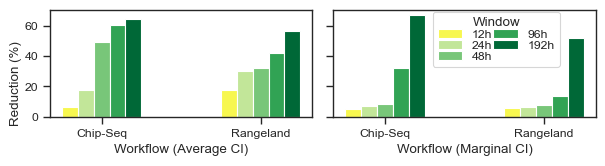

In [10]:
# Interrupted Workflow Shifting Graph
groups = len(only_workflows)
ind = np.arange(groups)  # x locs for each workflow group
width = 0.1  # width of each bar

fig, axs = plt.subplots(1, 2, figsize=(6, 1.75), sharey=True)

red_12h_grp = [] 
red_24h_grp = []
red_48h_grp = []
red_96h_grp = []
red_192h_grp = []
results_avg = parse_ts_summary_file('data/temporal-shifting/interrupt-wf/avg/workflows-ts.csv')

for workflow in only_workflows:
    red_6h = results_avg[workflow]['6H_REDUCTION']
    red_12h_grp.append(red_6h)
    red_12h = results_avg[workflow]['12H_REDUCTION']
    red_24h_grp.append(red_12h)
    red_24h = results_avg[workflow]['24H_REDUCTION']
    red_48h_grp.append(red_24h)
    red_48h = results_avg[workflow]['48H_REDUCTION']
    red_96h_grp.append(red_48h)
    red_96h = results_avg[workflow]['96H_REDUCTION']
    red_192h_grp.append(red_96h)
    
g1 = axs[0].bar(ind - width, red_12h_grp, width, color='#f7f74f')
g2 = axs[0].bar(ind, red_24h_grp, width, color='#c2e699')
g3 = axs[0].bar(ind + width, red_48h_grp, width, color='#78c679')
g4 = axs[0].bar(ind + (width * 2), red_96h_grp, width, color='#31a354')
g5 = axs[0].bar(ind + (width * 3), red_192h_grp, width, color='#006837')

results_marg = parse_ts_summary_file('data/temporal-shifting/interrupt-wf/marg/workflows-ts.csv')
red_12h_grp = [] 
red_24h_grp = []
red_48h_grp = []
red_96h_grp = []
red_192h_grp = []

for workflow in only_workflows:
    red_6h = results_marg[workflow]['6H_REDUCTION']
    red_12h_grp.append(red_6h)
    red_12h = results_marg[workflow]['12H_REDUCTION']
    red_24h_grp.append(red_12h)
    red_24h = results_marg[workflow]['24H_REDUCTION']
    red_48h_grp.append(red_24h)
    red_48h = results_marg[workflow]['48H_REDUCTION']
    red_96h_grp.append(red_48h)
    red_96h = results_marg[workflow]['96H_REDUCTION']
    red_192h_grp.append(red_96h)

g1 = axs[1].bar(ind - width, red_12h_grp, width, color='#f7f74f')
g2 = axs[1].bar(ind, red_24h_grp, width, color='#c2e699')
g3 = axs[1].bar(ind + width, red_48h_grp, width, color='#78c679')
g4 = axs[1].bar(ind + (width * 2), red_96h_grp, width, color='#31a354')
g5 = axs[1].bar(ind + (width * 3), red_192h_grp, width, color='#006837')

axs[0].set_xticks(ind+width)
axs[0].set_xticklabels(['Chip-Seq', 'Rangeland'])
axs[1].set_xticks(ind+width)
axs[1].set_xticklabels(['Chip-Seq', 'Rangeland'])
fig.legend((g1, g2, g3, g4, g5), ('12h', '24h', '48h', '96h', '192h'), title='Window', loc='upper center', bbox_to_anchor=(0.81, 0.94), ncol=2, labelspacing=0.04, columnspacing=0.06)

fig.text(0.01, 0.5, 'Reduction (%)', ha='center', va='center', rotation='vertical')
axs[0].set_xlabel('Workflow (Average CI)')
axs[1].set_xlabel('Workflow (Marginal CI)')

plt.tight_layout()
plt.savefig('images/interrupt-flex-limited.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# Resource Scaling - Resource Assignment
ci_interval = 'ca-01102023-31122023'
res_avg_data = {}
nodes = ['cluster-node-default', 'edge-server-default']

headers = ['task', 'node', 'runtime (h)', 'energy consumption (kWh)', 'marginal emissions (gCO2e)']
task = 'trimgalore'
table_data = []

# Marginal
for node in nodes:
    res_avg_data[node] = {}
    res_avg_data[node] = {}
    res_avg_data[node][task] = {}
    (info_1, data_1, bonus_1) = parse_summary(f'data/resource-scaling/nodes/{node}/{task}-1-{ci_interval}-marg-5m-linear-summary.txt')
    (info_2, data_2, bonus_2) = parse_summary(f'data/resource-scaling/nodes/{node}/{task}-2-{ci_interval}-marg-5m-linear-summary.txt')
    (info_3, data_3, bonus_3) = parse_summary(f'data/resource-scaling/nodes/{node}/{task}-3-{ci_interval}-marg-5m-linear-summary.txt')

    average = get_average(data_1, data_2, data_3)
    average_runtime = sum([bonus_1['runtime'], bonus_2['runtime'], bonus_3['runtime']]) / 3
    avg_energy_consumption = average[ENERGY_CONSUMPTION] + average[MEMORY_CONSUMPTION]

    marginal = get_average(data_1, data_2, data_3)
    marg_ems = marginal[CARBON_EMISSIONS]
    res_avg_data[node][task]['energy'] = round(avg_energy_consumption,2)
    res_avg_data[node][task]['runtime'] = round(average_runtime / 1000 / 3600, 2)  # runtime of task in hours (converted from ms) 
    res_avg_data[node][task]['marg-emissions'] = round(marg_ems, 2)
    table_data.append([task, node, res_avg_data[node][task]['runtime'], res_avg_data[node][task]['energy'], res_avg_data[node][task]['marg-emissions']])

print("Comparison of Tasks on Different Machines using Marginal CI Data")
print(tabulate(table_data, headers, tablefmt='orgtbl'))

Comparison of Tasks on Different Machines using Marginal CI Data
| task       | node                 |   runtime (h) |   energy consumption (kWh) |   marginal emissions (gCO2e) |
|------------+----------------------+---------------+----------------------------+------------------------------|
| trimgalore | cluster-node-default |          0.55 |                       0.07 |                        37.87 |
| trimgalore | edge-server-default  |          0.84 |                       0.02 |                        13.82 |


In [18]:
# Resource Scaling - Frequency Scaling
ci_interval = 'nl-01062023-31072023'
res_avg_data = {}
nodes = ['cluster-node-4ghz', 'cluster-node-3ghz', 'cluster-node-2ghz']

headers = ['task', 'node', 'runtime (h)', 'energy consumption (kWh)', 'marginal emissions (gCO2e)']
task = 'trimgalore'
table_data = []

# Marginal
for node in nodes:
    res_avg_data[node] = {}
    res_avg_data[node] = {}
    res_avg_data[node][task] = {}
    (info_1, data_1, bonus_1) = parse_summary(f'data/resource-scaling/nodes/{node}/{task}-1-{ci_interval}-marg-5m-linear-summary.txt')
    (info_2, data_2, bonus_2) = parse_summary(f'data/resource-scaling/nodes/{node}/{task}-2-{ci_interval}-marg-5m-linear-summary.txt')
    (info_3, data_3, bonus_3) = parse_summary(f'data/resource-scaling/nodes/{node}/{task}-3-{ci_interval}-marg-5m-linear-summary.txt')

    average = get_average(data_1, data_2, data_3)
    average_runtime = sum([bonus_1['runtime'], bonus_2['runtime'], bonus_3['runtime']]) / 3
    avg_energy_consumption = average[ENERGY_CONSUMPTION] + average[MEMORY_CONSUMPTION]

    marginal = get_average(data_1, data_2, data_3)
    marg_ems = marginal[CARBON_EMISSIONS]
    res_avg_data[node][task]['energy'] = round(avg_energy_consumption,3)
    res_avg_data[node][task]['runtime'] = round(average_runtime / 1000 / 3600, 2)  # runtime of task in hours (converted from ms) 
    res_avg_data[node][task]['marg-emissions'] = round(marg_ems, 2)
    table_data.append([task, node, res_avg_data[node][task]['runtime'], res_avg_data[node][task]['energy'], res_avg_data[node][task]['marg-emissions']])

print("Comparison of Tasks at different frequencies Marginal CI Data")
print(tabulate(table_data, headers, tablefmt='orgtbl'))

Comparison of Tasks at different frequencies Marginal CI Data
| task       | node              |   runtime (h) |   energy consumption (kWh) |   marginal emissions (gCO2e) |
|------------+-------------------+---------------+----------------------------+------------------------------|
| trimgalore | cluster-node-4ghz |          0.54 |                      0.086 |                        51.55 |
| trimgalore | cluster-node-3ghz |          0.68 |                      0.105 |                        50.54 |
| trimgalore | cluster-node-2ghz |          1.04 |                      0.095 |                        30.37 |


In [ ]:
# Resource Scaling - Cluster
ci = 'de-01102023-31122023'
cluster_scale_paths = [[f'data/resource-scaling/cluster/nodes-{nodes}/results/chipseq-{iteration}-{ci}-summary.txt' for iteration in range(1,4)] for nodes in [2, 4, 8]]
print('Resource Scaling - Cluster Level')

for paths, nodes in zip(cluster_scale_paths, [2, 4, 8]):
    (info_1, data_1, bonus_1) = parse_summary(paths[0])
    (info_2, data_2, bonus_2) = parse_summary(paths[1])
    (info_3, data_3, bonus_3) = parse_summary(paths[2])
    average = get_average(data_1, data_2, data_3)
    average_runtime = sum([bonus_1['runtime'], bonus_2['runtime'], bonus_3['runtime']]) / 3
    avg_energy_consumption = average[ENERGY_CONSUMPTION] + average[MEMORY_CONSUMPTION]
    avg_ems = average[CARBON_EMISSIONS]
    avg_runtime = round(average_runtime / 1000 / 3600, 2)  # runtime of task in hours (converted from ms) 

    (info_1, data_1, bonus_1) = parse_summary(paths[0].replace(ci, ci + '-marg'))
    (info_2, data_2, bonus_2) = parse_summary(paths[1].replace(ci, ci + '-marg'))
    (info_3, data_3, bonus_3) = parse_summary(paths[2].replace(ci, ci + '-marg'))
    marg_average = get_average(data_1, data_2, data_3)
    marg_average_runtime = sum([bonus_1['runtime'], bonus_2['runtime'], bonus_3['runtime']]) / 3
    marg_avg_energy_consumption = marg_average[ENERGY_CONSUMPTION] + marg_average[MEMORY_CONSUMPTION]
    marg_avg_ems = marg_average[CARBON_EMISSIONS]
    marg_avg_runtime = round(marg_average_runtime / 1000 / 3600, 2)  # runtime of task in hours (converted from ms) 

    print(f'{nodes} nodes: {avg_energy_consumption} kWh, {avg_ems} gCO2e, {marg_avg_ems} gCO2e')

Resource Scaling - Cluster Level
2 nodes: 34.12749389875677 kWh, 11862.160139205438 gCO2e, 25387.299936975673 gCO2e
4 nodes: 34.39214548413526 kWh, 9616.606864511514 gCO2e, 25968.875200546332 gCO2e
8 nodes: 34.166272320237006 kWh, 6817.3453585983 gCO2e, 23639.87715360982 gCO2e
